In [1]:
from functools import partial
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet50
import torchmetrics

In [2]:
batch_size = 256
max_epochs = 40

In [3]:
class BarlowTwinsTransform:
    def __init__(self, input_height=32, jitter_strength=0.5, normalize = True):
        self.input_height = input_height
        self.jitter_strength = jitter_strength

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        self.color_transform = transforms.Compose([transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)])

        normalization = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])

        if normalize:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalization])
        else:
            self.final_transform = transforms.ToTensor()

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )


    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.final_transform(sample)

Files already downloaded and verified


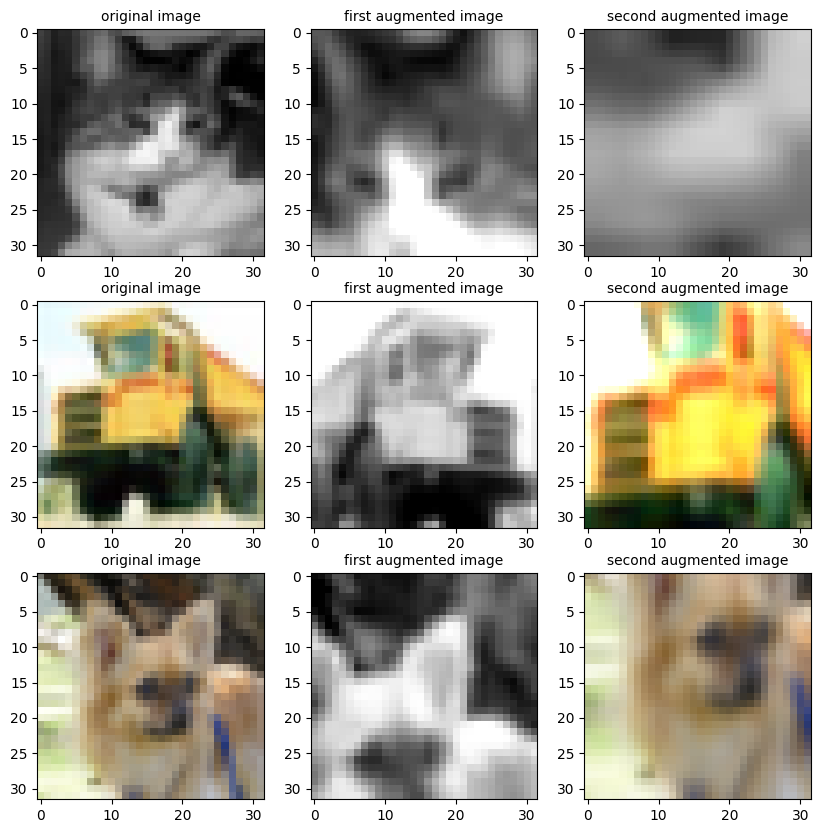

In [4]:
example_transform = BarlowTwinsTransform(normalize = False)
example_dataset = CIFAR10(root=".", train=False, download=True, transform=example_transform)

plt.figure(figsize=(10,10))
samples = np.random.randint(0, len(example_dataset), size=3)
for i, num in enumerate(samples):
    (img1, img2, img3), label = example_dataset.__getitem__(num)
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(np.transpose(img1, (1, 2, 0)))
    plt.title("first augmented image", fontsize=10)
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    plt.title("second augmented image", fontsize=10)
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(np.transpose(img3, (1, 2, 0)))
    plt.title("original image", fontsize=10)
plt.show()

In [5]:
train_transform = BarlowTwinsTransform()
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)
val_transform = BarlowTwinsTransform()
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=0.0051):
        super().__init__()
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)
        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size
        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()
        return on_diag + self.lambda_coeff * off_diag

In [7]:
backbone = resnet50()
backbone.fc = nn.Identity()

In [8]:
class Projector(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=1024, output_dim=512):
        super().__init__()

        self.projector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projector(x)

In [9]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0

def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

In [10]:
class BarlowTwins(L.LightningModule):
    def __init__(
        self,
        backbone,
        num_training_samples,
        batch_size,
        max_epochs,
        lambda_coeff=0.0051,
        learning_rate=0.001,
        warmup_epochs=10,
    ):
        super().__init__()

        self.backbone = backbone
        self.projector = Projector()
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size)
        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.backbone(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch
        z1 = self.projector(self.backbone(x1))
        z2 = self.projector(self.backbone(x2))
        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar = True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }
        return [optimizer], [scheduler]

In [11]:
model = BarlowTwins(
    backbone=backbone,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    max_epochs=max_epochs
)
model = model.to('cuda')

trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | backbone  | ResNet          | 23.5 M
1 | projector | Projector       | 2.6 M 
2 | loss_fn   | BarlowTwinsLoss | 0     
----------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.530   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [13]:
class Classifier(L.LightningModule):
  def __init__(self, model, learning_rate = 0.001):
    super().__init__()
    self.model = model
    self.learning_rate = learning_rate
    self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    self.f1score = torchmetrics.F1Score(task="multiclass", num_classes=10)

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar = True)
    self.log("train_acc", acc, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    self.log("val_loss", loss, prog_bar = True)
    self.log("val_acc", acc, prog_bar = True)
    return loss

  def test_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    f1 = self.f1score(preds, labels)
    self.log("test_loss", loss, prog_bar = True)
    self.log("test_acc", acc, prog_bar = True)
    self.log("test_f1", f1, prog_bar = True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    scheduler = {
        "scheduler": torch.optim.lr_scheduler.LambdaLR(
            optimizer,
            linear_warmup_decay(620),
        ),
        "interval": "step",
        "frequency": 1,
        }
    return [optimizer], [scheduler]

In [14]:
trained_backbone = model.backbone
for param in trained_backbone.parameters():
  param.requires_grad = False
trained_backbone.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
supervised_model = Classifier(trained_backbone).to('cuda')

In [15]:
transform = BarlowTwinsTransform()
dataset = CIFAR10(root=".", train=False, download=True, transform=transform)
train_dataset2, test_dataset = torch.utils.data.random_split(dataset, [8000, 2000])
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Files already downloaded and verified


In [16]:
trainer = L.Trainer(
    max_epochs=20,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(supervised_model, train_loader2, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 23.5 M
1 | accuracy | MulticlassAccuracy | 0     
2 | f1score  | MulticlassF1Score  | 0     
------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/askari/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
result = trainer.test(supervised_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5279017686843872     │
│          test_f1          │    0.5279017686843872     │
│         test_loss         │    1.3342753648757935     │
└───────────────────────────┴───────────────────────────┘